<a href="https://colab.research.google.com/github/nicolaiberk/Imbalanced/blob/master/02c_ActiveLearning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Active Learning with `ModAL`

One way to address imbalanced data problems is to actively sample the most informative cases. This method is called Active Learning - active because the classifier 'decides' which cases should be annotated next. This notebook mainly builds on a [paper](http://www-personal.umich.edu/~wmebane/active-learning-approaches-4-18-2018.pdf) on Active Learning published in Political Analysis, from which the graphic below is taken as well.


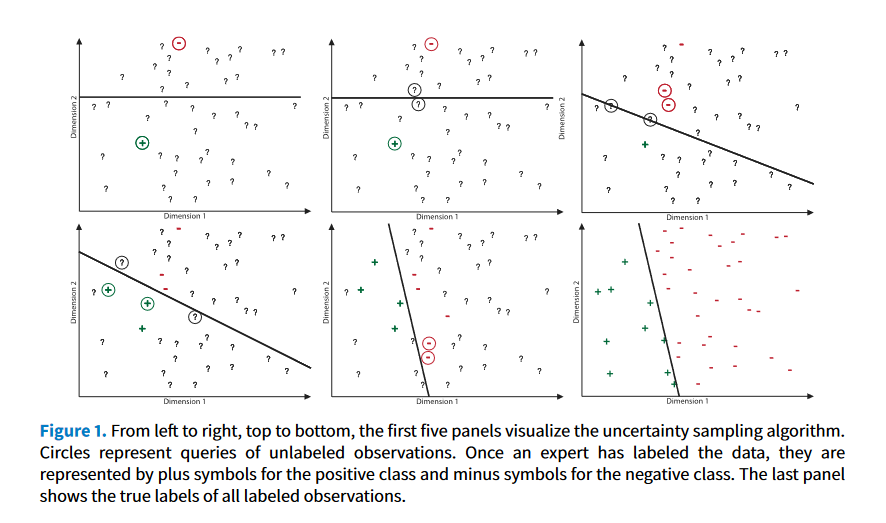

We use a highly imbalanced dataset of tweets that were annotated using crowd-coding from the replication materials of [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3026393). The tweets are classified according to whether they discuss the refugee movements in 2015. We will use the `modAL` package to implement Active Learning.

We start by importing the packages and loading the data.

In [1]:
## setup and load data

# load relevant packages
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ___
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ___
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

# set seed
np.random.seed(42)

# define vectoriser
vec = ___()

# load data
corpus = pd.read_csv("https://www.dropbox.com/s/gv56nu1ptrp63ps/annotated_german_refugee_tweets.csv?dl=1")
# corpus = corpus.sample(10000)

In [ ]:
corpus.head()

In [ ]:
corpus.shape

The corpus contains the text 24,420 tweets and a variable called 'annotation' containing the label of interest. We drop the remaining variables and split the data into a train and a test set:

In [4]:
## we only need two variables: outcome and text
corpus = corpus[["annotation", "___"]]

In [5]:
# general train/test split for assessment of performance
#     and vectorize

X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(
    ____,
    ____,
    test_size=0.20,
    random_state=42
)

# reset indices
X_train_raw = X_train_raw.reset_index(drop = True)
X_test_raw = X_test_raw.reset_index(drop = True)
y_train_raw = y_train_raw.reset_index(drop = True)
y_test = np.array(y_test.reset_index(drop = True))

del corpus

# Active Learning in Python

## Cold Phase/Initialisation

To start, we need a small random sample. This is necessary to train an initial classifier making uncertainty estimates about our unlabelled data. The size of this starting set will depend on the rareness of the outcome - it has to come up at least once. Let's sample 500 cases for a cold start:

In [ ]:
# draw random initialisation sample
n_initial = 1000

rng = np.random.default_rng(42)
initial_idx = np.random.choice(range(X_train_raw.shape[0]), size=n_initial, replace=False)

X_start = X_train_raw[initial_idx]
y_start = np.array(y_train_raw[initial_idx])

# drop starting sample from training sample
mask = np.ones(X_train_raw.shape[0], dtype=bool)
mask[initial_idx] = False
X_train_raw = X_train_raw[mask].reset_index(drop = True) 
y_train_raw = y_train_raw[mask].reset_index(drop = True)

# transform data for feeding into classifier
X_train = vec.____(np.array(X_train_raw))
y_train = np.array(y_train_raw)
X_test = vec.transform(X_test_raw)


print(f"{sum(y_start)} positive cases out of a set of {len(y_start)} in the starting set ({round(sum(y_start)*100/len(y_start), 2)}%).")
pd.Series(y_start).value_counts().plot(kind='bar', title='Class distribution in starting set')

We have a few tweets about the refugee situation in 2015 in our dataset. It's not much, but it is sufficient to initialise our active learner.

We will use the `modAL` package, which integrates well with `scikit-learn` and provides some great [documentation](modal-python.readthedocs.io/).

In [7]:
# first install modAL package
!pip install modAL

In [8]:
# import modAL
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

X_start = vec.transform(X_start)

# initializing the learner
learner = ActiveLearner(
    estimator=____,
    X_training=X_start, y_training=y_start
)



The 'learner' is initialised with the starting data - time for the *Hot Phase*!

## Active Phase

### General logic

We ask the estimator which is the sample it is most unsure about:

In [9]:
# query for label
query_idx, query_inst = learner.___(X_train)

In [10]:
X_train_raw[____].item()

'RT @Marvin_Ronsdorf: Die niederländischen Nationalspieler können das Auswärtsspiel gegen das @DFB_Team in Hannover am 17.11. sicher gar nic…'

And provide the sample to the learner with the relevant label:

In [11]:
 y_train[query_idx]

array([0.])

In [12]:
learner.teach(X_train[query_idx], ____[query_idx])

Now we need to drop the observation from the training set in order to look for the next most informative one,

In [13]:
# delete coded example from training sample
mask = np.ones(X_train.shape[0], dtype=bool)
mask[query_idx] = False

X_train = X_train[mask] 
y_train = y_train[mask]

Supply the new label to the classifier and ask for additional labels:

In [14]:
query_idx, query_inst = _____.____(X_train)
print(X_train_raw[query_idx].item())
learner.teach(_____, y_train[query_idx])

# delete coded example from training sample
mask = np.ones(X_train.shape[0], dtype=bool)
mask[query_idx] = False

X_train = X_train[mask] 
y_train = y_train[mask]

Aber egal was du tust, ich wünsche dir nur, dass du glücklich wirst... auf deine Art. Egal was war! #lasttweet #nächtlichesgetwitter


Of course, this could be done more efficiently in a loop:

In [15]:
for i in range(5):
  query_idx, query_inst = learner.____(_____)
  print(X_train_raw[query_idx].item())
  learner.teach(X_train[_____], _____)

  # delete coded example from training sample (takes a bit due to transformation)\
  mask = np.ones(X_train.shape[0], dtype=bool)
  mask[query_idx] = False

  X_train = X_train[mask] 
  y_train = y_train[mask]

@bonsai__ ich habe dasselbe mit sky vor :D wünsche gute jagt ^u^
Der @KlonBlog verlost einen Saugroboter von #Vorwerk da muss ich mitmachen! #Gewinnspiel #KBGewinnspiel https://t.co/mR7dEbkA9k
adsnbfner #KCAArgentina #RuggeroPasquarelli
Ich habe die Aufgabe \Ein vorteilhaftes Ding\ abgeschlossen! http://t.co/gRovTL5Urv #ipad #gameinsight #ipadgames
RT @Iris_Rohmann: #Kölner gegen #Pegida und Co. https://t.co/dwwqqXDWPp


### Annotation by Hand

The common use case won't be the supply of existing labels but the use of Active Learning for informed annotation. The script below provides some text and asks for the appropriate label:

In [16]:
# we can also annotate by hand - check rubix for more info
n_queries = 3
for i in range(n_queries):
  
  # get most informative label
  query_idx, query_inst = learner.query(X_train)

  # print text
  display.clear_output(wait=True) # clear any existing text
  print(X_train_raw[query_idx].item())

  # display questions and text field
  print("\n\nIs this a tweet about migration? ('1' = yes, '0' = no)?\n")
  y_new = np.array([int(input())], dtype=int)

  # update model
  learner.teach(query_inst, y_new)

  # delete coded example from training sample
  mask = np.ones(X_train.shape[0], dtype=bool)
  mask[query_idx] = False

  X_train = X_train[mask] 
  y_train = y_train[mask]

RT @tagesschau: Pro Asyl zu CSU-Plänen: \Populistisch und unrealistisch\ https://t.co/FHDHsGrqvB #ProAsyl #Flüchtlinge #CSU


Is this a tweet about refugees? ('1' = yes, '0' = no)?

1


### Batch Sampling and Comparative Performance

As the looping over single observations takes ages, we can also use batch sampling to query a certain number of uncertain samples rather than a single one. This way, we can annotate several at the same time, but also give away a bit of learning - instead of updating with every newly supplied label, we only do so every 25 labels or so.

We first prepare a classifier that is trained on random data which we can compare to our batch learner. We create lists to track performance of the classifiers while they run.

In [17]:
# train classifier on random sample for comparison

# define and fit classifier
passive_clsfr = ____
passive_clsfr.fit(X_start, _____)

# assess performance
y_pred_passive = ______

accuracy_passive = [accuracy_score(y_test, y_pred_passive)]
recall_passive = [recall_score(y_test, y_pred_passive)]
precision_passive = [precision_score(y_test, y_pred_passive)]
f1_passive = [f1_score(y_test, y_pred_passive)]

We define the active learner with a batch size of 100 for uncertainty sampling. This means the classifier will always return the 100 most uncertain predictions, which are then fed back with annotation to get the next 100. This is of course less informative than updating the classifier every iteration. 

In [18]:
# define learner for batch sampling

from functools import partial
from modAL.batch import uncertainty_batch_sampling

# Pre-set our batch sampling to retrieve 50 samples at a time.
batch_size = 100
preset_batch = partial(uncertainty_batch_sampling, n_instances=batch_size)

# Specify our active learning model.
batch_learner = ActiveLearner(
  estimator=_____,

  X_training=X_start,
  y_training=y_start,

  query_strategy=preset_batch
)

# generate deepcopies from training set that can be used up
X_train = vec.fit_transform(np.array(X_train_raw))
y_train = np.array(y_train_raw)
X_test = vec.transform(X_test_raw)

X_pool = deepcopy(X_train)
y_pool = deepcopy(y_train)

In [19]:
# performance of initialised active learner
accuracy_scores = [accuracy_score(y_test, batch_learner.predict(X_test))]
recall_scores = [recall_score(y_test, batch_learner.predict(X_test))]
precision_scores = [precision_score(y_test, batch_learner.predict(X_test))]
f1_scores = [f1_score(y_test, batch_learner.predict(X_test))]
training_progress = [n_initial]

The next bit takes a long time - ideally you wouldn't run it now but take the code to adapt it ot your needs (the planet thanks you for your patience).

Active F1 after query 15: 0.3333
Passive F1 after query 15: 0.0145


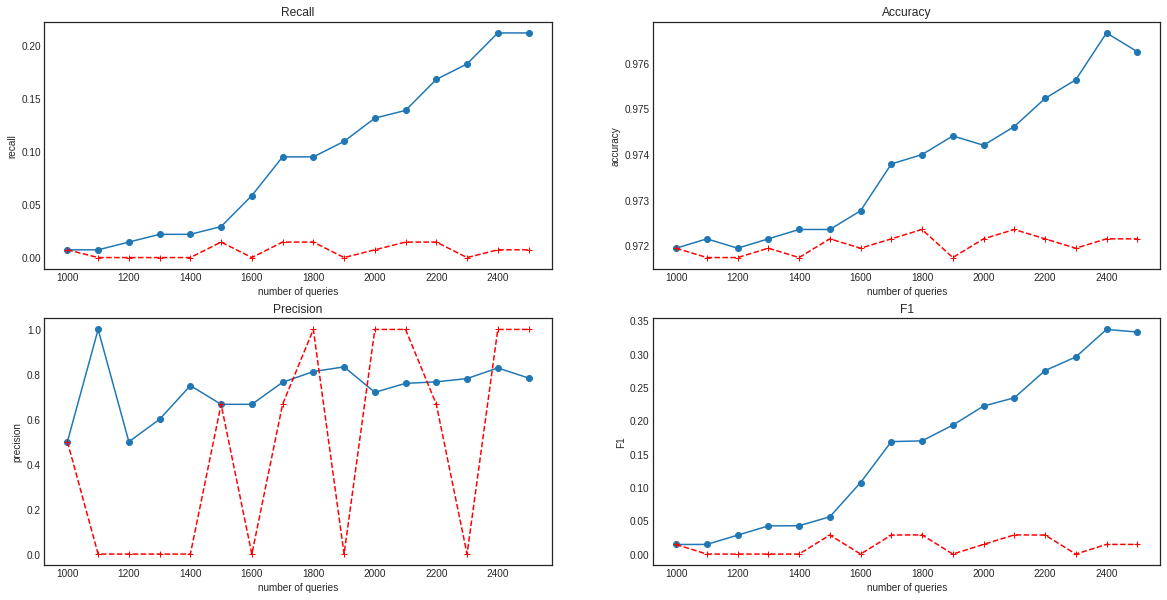

In [20]:
# this bit takes a while
learner_scores = [batch_learner.score(X_test, y_test)]

sample_size = 2500
n_queries = (sample_size - n_initial) // batch_size

for i in range(n_queries):
  display.clear_output(wait=True)

  # all that matters are the next few lines
  query_idx, query_inst = batch_learner.query(X_pool) # obtain uncertainty estimates for full training sample
  X, y = X_pool[query_idx], y_pool[query_idx]
  batch_learner.teach(X=X, y=y)

  ## delete newly annotated from training pool
  mask = np.ones(X_pool.shape[0], dtype=bool)
  mask[query_idx] = False
  X_pool = X_pool[mask] 
  y_pool = y_pool[mask]
  
  ## assess performance
  training_progress.append(n_initial + (i+1)*batch_size)
  accuracy_scores.append(accuracy_score(y_test, batch_learner.predict(X_test)))
  recall_scores.append(recall_score(y_test, batch_learner.predict(X_test))) 
  precision_scores.append(precision_score(y_test, batch_learner.predict(X_test))) 
  active_f1 = f1_score(y_test, batch_learner.predict(X_test))
  f1_scores.append(active_f1) 
  
  print('Active F1 after query {n}: {acc:0.4f}'.format(n=i + 1, acc=active_f1))



  # random classifier performance
  
  ## draw sample
  rand_sample = np.random.choice([i for i in range(len(y_pool))], n_initial+(i+1)*batch_size, replace=False)
  X_train_passive = X_pool[rand_sample]
  y_train_passive = y_pool[rand_sample]

  ## define and fit classifier
  passive_clsfr = LogReg(max_iter=1000)
  passive_clsfr.fit(X_train_passive, y_train_passive)

  ## assess performance
  y_pred_passive = passive_clsfr.predict(X_test)
  accuracy_passive.append(accuracy_score(y_test, y_pred_passive))
  recall_passive.append(recall_score(y_test, y_pred_passive)) 
  precision_passive.append(precision_score(y_test, y_pred_passive)) 
  passive_f1 = f1_score(y_test, y_pred_passive)
  f1_passive.append(passive_f1) 

  print('Passive F1 after query {n}: {acc:0.4f}'.format(n=i + 1, acc=passive_f1))


  # the remainder is only for plotting

  with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.title('Recall')
    plt.plot(training_progress, recall_scores, marker = "o")
    plt.plot(training_progress, recall_passive, color = 'red', ls = "--", marker='+')
    plt.xlabel('number of queries')
    plt.ylabel('recall')
    plt.subplot(2, 2, 2)
    plt.title('Accuracy')
    plt.plot(training_progress, accuracy_scores, marker = "o")
    plt.plot(training_progress, accuracy_passive, color = 'red', ls = "--", marker='+')
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.subplot(2, 2, 3)
    plt.title('Precision')
    plt.plot(training_progress, precision_scores, marker = "o")
    plt.plot(training_progress, precision_passive, color = 'red', ls = "--", marker='+')
    plt.xlabel('number of queries')
    plt.ylabel('precision')
    plt.subplot(2, 2, 4)
    plt.title('F1')
    plt.plot(training_progress, f1_scores, marker = "o")
    plt.plot(training_progress, f1_passive, color = 'red', ls = "--", marker='+')
    plt.xlabel('number of queries')
    plt.ylabel('F1')
    display.display(plt.gcf())
    plt.close('all')      


We can see that the active classifier clearly outperforms the random one on every metric.